# Introduction

This dashboard shows a comprehensive view of our final term project, which is a database for an online bookstore. We create SQL queries in order to answer several analytical questions. We also use several Python libraries for visualization.

# The dataset

For this analysis, we will use the Bookstore database which contains eleven tables all relating to the operations of an online bookstore. With tables like `Author` and `Publisher`, this dataset provides insight into the functions of a small business. An Entity-Relationship Diagram (ERD) of the data containing details about attribute specifiations and entity cardinality can be found here: [Bookstore ERD](https://lucid.app/lucidchart/0dd28d02-6be6-4785-b35e-c068cc446725/edit?invitationId=inv_d32bf71b-1953-441b-a21f-8b65784b16bf&page=0_0#).

- Add more about generating the dummy data

We will start off by defining some helper functions for connecting to the database:

In [ ]:
import sys
!pip install pandas
!pip install numpy
!pip install datapane
!pip install plotly
!pip install pymysql

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.6/143.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.2/731.2 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.4/244.4 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.1 MB/s eta 0:00:00
  Created wheel for micawber: filename=micawber-0.5.6-py3-none-any.whl size=22457 sha256=31aec33ec330229978ecb6c0e3817af8b5e17c5ef07f6bef3b9e1c8229dfed0b
  Stored in directory: /root/.cache/pip/wheels/74/e3/a2/e7072ad68319f81a1aa33ab2724210e6c71b3e72e58dd0f847
Successfully built micawber
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
  

In [ ]:
# import sqlite3
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import datapane as dp
import pymysql
import warnings
import pymysql
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')



In [ ]:
host = 'bookstore-mis686.cgwdjwsa3unq.us-east-1.rds.amazonaws.com'
user = 'admin'
password = 'passwordMIS686'
database = 'Bookstore'

connection = pymysql.connect(host=host, user=user, passwd=password, database=database)
with connection:
    cur = connection.cursor()
    cur.execute("SELECT VERSION()")
    version = cur.fetchone()
    print("Database version: {} ".format(version[0]))

Database version: 8.0.39 


In [ ]:

def run_query(q: str) -> pd.DataFrame:
    with pymysql.connect(host=host, user=user, passwd=password, database=database) as conn:
        return pd.read_sql(q, conn)


def run_command(c: str):
    with pymysql.connect(host=host, user=user, passwd=password, database=database) as conn:
        conn.isolation_level = None
        conn.execute(c)

Now that we have established a connection to the database and the functions have been set up to run SQL commands inside of Python code, we can proceed with displaying the tables and their respective row counts.

In [ ]:
def show_tables() -> pd.DataFrame:
    q = """
          SELECT table_name
          FROM information_schema.tables
          WHERE table_schema = 'Bookstore' AND table_type = 'BASE TABLE';
        """
    return run_query(q)


def get_table_row_count(tablename) -> int:
    q = (
        """
        SELECT
            COUNT(1)
        FROM %s;
        """
        % tablename
    )
    return run_query(q)["COUNT(1)"][0]


tables = show_tables()
tables["row_count"] = [get_table_row_count(t) for t in tables['TABLE_NAME']]

tables

,TABLE_NAME,row_count
0,Author,25
1,Book,25
2,Customer,25
3,Inventory,25
4,InventorySupplier,25
5,OrderItem,34
6,Orders,25
7,Payment,25
8,Publisher,25
9,Returns,25


# Simple Analytical Questions


## 1. How many books do we have in stock for each genre?

In [ ]:
import datapane as dp

genre_count_query = """
SELECT B.Genre, SUM(I.QuantityInStock) AS 'Inventory Count'
FROM Bookstore.Inventory I
LEFT JOIN Bookstore.Book B ON I.InventoryID = B.InventoryID
GROUP BY B.Genre
ORDER BY SUM(I.QuantityInStock) DESC;
"""

genre_count_df = run_query(genre_count_query)

dp.DataTable(genre_count_df)

We first need to join the `Book` and `Inventory` tables so we have access to both the inventory supply and the books' genres. Grouping by `Genre` allows us to use the aggregate function `SUM()` on `QuantityInStock` to compute the number in stock for each genre, shown in the result table. We can see that the bookstore's top genres are Science Fiction and Mystery.

## 2. How much revenue has the bookstore made from orders based on status?

In [ ]:
completed_order_revenue_query = """
SELECT SUM(TotalAmount) AS 'Revenue', OrderStatus
FROM Bookstore.Orders
GROUP BY OrderStatus
ORDER BY Revenue DESC;
"""

completed_revenue_df = run_query(completed_order_revenue_query)

dp.DataTable(completed_revenue_df)

To find out how much revenue the bookstore has made for orders of different status, we need to use the `GROUP BY` clause on the `OrderStatus` column. By displaying the sum of `TotalAmount`, we can see that the highest revenue was made from 'Processing' orders, whcih is $449.23.

## 3. What is the average rating given by each customer that has completed at least one review?

In [ ]:
review_customer_query = """
SELECT C.CustomerID, C.FirstName, C.LastName, AVG(R.Rating) AS 'Average Rating'
FROM Bookstore.Review R
RIGHT JOIN Bookstore.Customer C ON C.CustomerID = R.CustomerID
WHERE R.ReviewID IS NOT NULL
GROUP BY R.CustomerID
ORDER BY CustomerID;
"""

review_df = run_query(review_customer_query)

dp.DataTable(review_df)

We first need to right join the `Customer` table to the `Review` table on `Customer.ID`. This ensures each customer appears in the table, regardless of whether they have given a review. By only selecting the rows where `R.ReviewID` is not null, we can see all of the

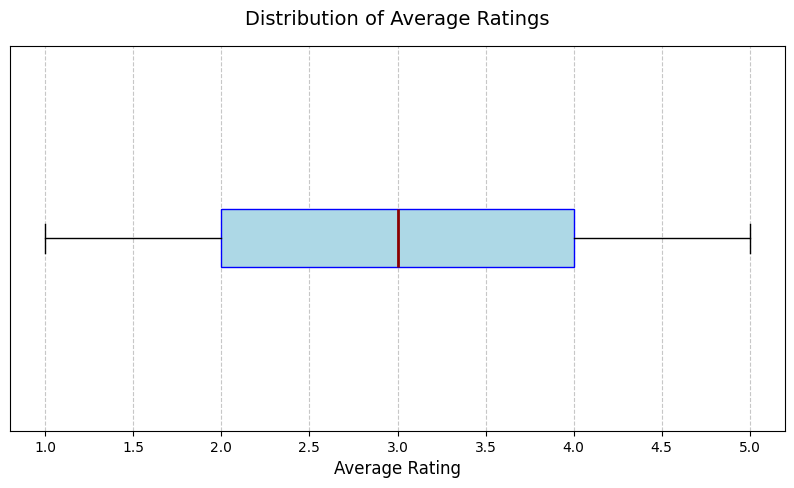

In [31]:
# visualize
fig7, ax7 = plt.subplots(figsize=(10, 5))

# Create a horizontal box plot
ax7.boxplot(
    review_df['Average Rating'],
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    medianprops=dict(color='darkred', linewidth=2)
)

# Add labels and title
ax7.set_title('Distribution of Average Ratings', fontsize=14, pad=15)
ax7.set_xlabel('Average Rating', fontsize=12)

ax7.set_yticks([])  # Remove all y-tick labels

# Add a grid for better readability
ax7.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Assign the plot to a variable
average_ratings_distribution_chart = fig7


## 4. What are the ten best-selling authors based on number of books sold?

In [ ]:
top_ten_authors_query = """
SELECT
    a.AuthorID,
    CONCAT(a.FirstName, ' ', a.LastName) AS AuthorName,
    SUM(oi.Quantity) AS TotalBooksSold
FROM Author a
JOIN Book b ON a.AuthorID = b.AuthorID
JOIN OrderItem oi ON b.BookID = oi.BookID
JOIN Orders o ON oi.OrderID = o.OrderID
WHERE o.OrderStatus IN ('Shipped', 'Delivered') -- Consider only completed orders
GROUP BY a.AuthorID, AuthorName
  ORDER BY TotalBooksSold DESC
LIMIT 10;
"""

top_ten_authors_df = run_query(top_ten_authors_query)

dp.DataTable(top_ten_authors_df)

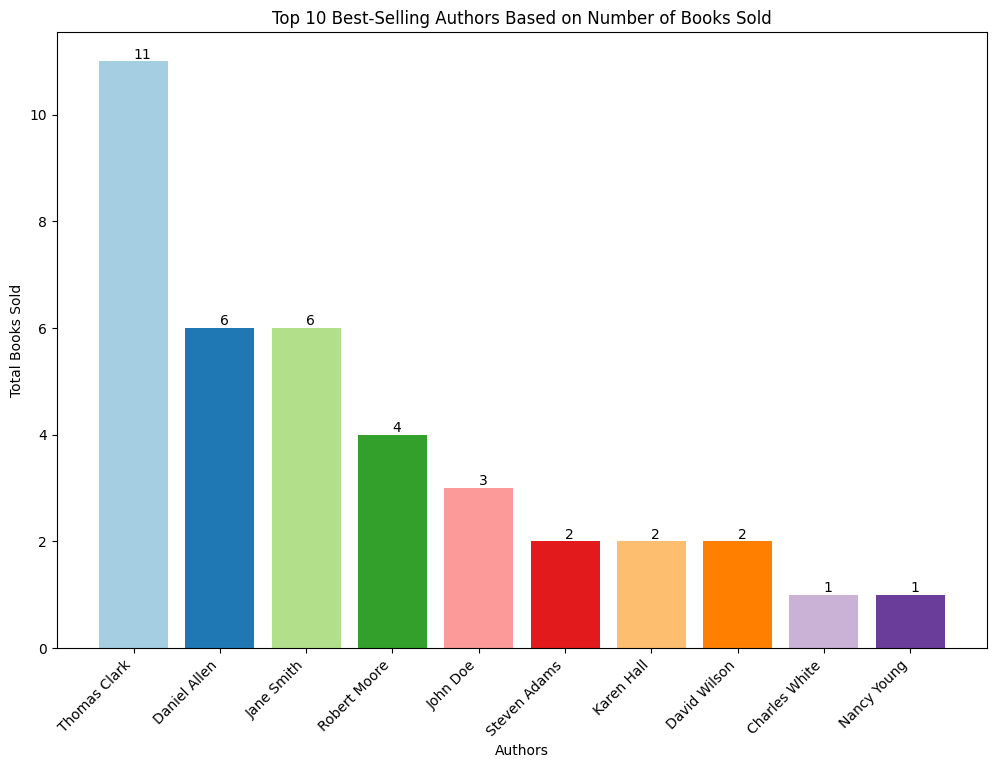

In [ ]:
# visualize
fig5, ax5 = plt.subplots(figsize=(12, 8))
bars = ax5.bar(top_ten_authors_df["AuthorName"], top_ten_authors_df["TotalBooksSold"], color=plt.cm.Paired(range(len(top_ten_authors_df["AuthorName"]))))

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom') # va: vertical alignment

# Rotate the x-axis labels to be diagonal
ax5.set_xticklabels(top_ten_authors_df["AuthorName"], rotation=45, ha='right')

# Add title and labels
ax5.set_title('Top 10 Best-Selling Authors Based on Number of Books Sold')
ax5.set_xlabel('Authors')
ax5.set_ylabel('Total Books Sold')

# Show the plot
plt.show()

top_ten_authors_chart = fig5

## 5. What are the top ten best-selling books based on number sold?

In [ ]:
top_ten_books_query = """
SELECT b.Title, CONCAT(a.FirstName, ' ', a.LastName) AS AuthorName, SUM(oi.Quantity) AS TotalSold
FROM Book b
JOIN OrderItem oi ON b.BookID = oi.BookID
JOIN Author a ON b.AuthorID = a.AuthorID
GROUP BY b.Title, AuthorName
ORDER BY TotalSold DESC
LIMIT 10;
"""

top_ten_books_df = run_query(top_ten_books_query)
top_ten_books_df["TotalSold"] = top_ten_books_df["TotalSold"].astype(int)
top_ten_books_df

,Title,AuthorName,TotalSold
0,The Enchanted Forest,Thomas Clark,9
1,The Hidden Cave,Steven Adams,6
2,Journey to Mars,Daniel Allen,5
3,Haunted House,David Wilson,4
4,AI Revolution,Jane Smith,4
5,Robots and AI,Robert Moore,4
6,Galactic Wars,Daniel Allen,3
7,Mystery at the Mansion,John Doe,2
8,The Lost Treasure,Charles White,2
9,Space Odyssey,Daniel Allen,2


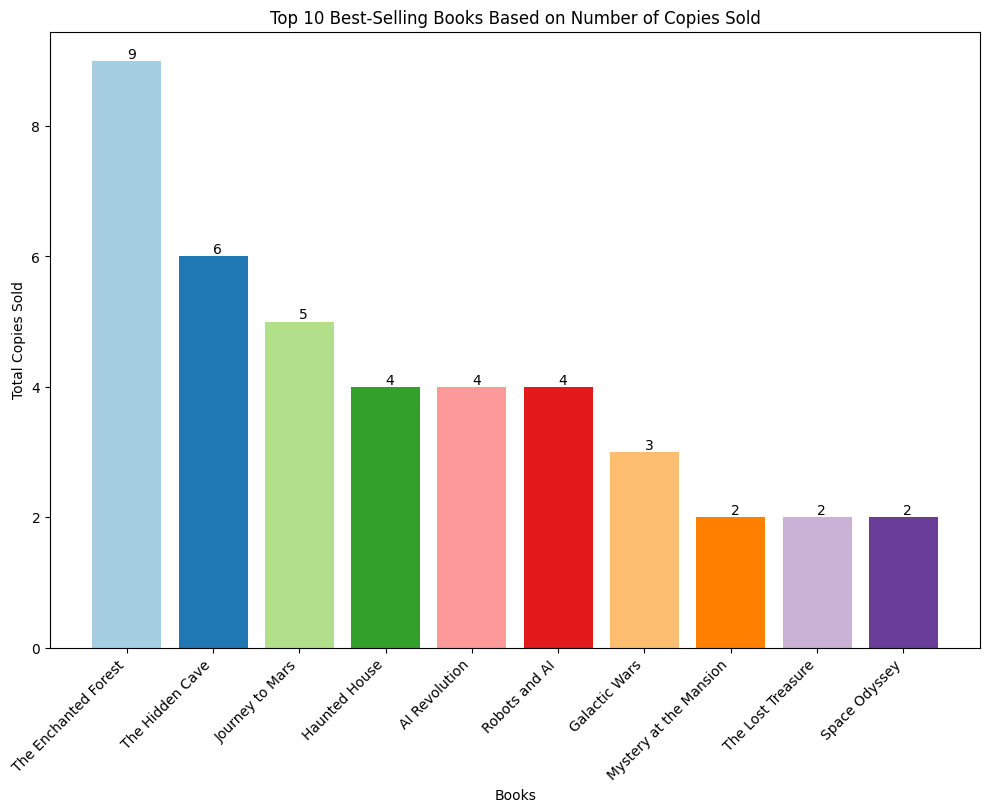

In [ ]:
# visualize with a bar chart
fig6, ax6 = plt.subplots(figsize=(12, 8))
bars = ax6.bar(top_ten_books_df["Title"], top_ten_books_df["TotalSold"], color=plt.cm.Paired(range(len(top_ten_books_df["Title"]))))

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom') # va: vertical alignment

# Rotate the x-axis labels to be diagonal
ax6.set_xticklabels(top_ten_books_df["Title"], rotation=45, ha='right')

# Add title and labels
ax6.set_title('Top 10 Best-Selling Books Based on Number of Copies Sold')
ax6.set_xlabel('Books')
ax6.set_ylabel('Total Copies Sold')

# Show the plot
plt.show()

top_ten_books_chart = fig6


# Complex Analytical Questions

## 1. What are the top 5 authors whose books have generated the most revenue?

In [ ]:
authors_revenue_query = """
SELECT A.AuthorID, A.FirstName, A.LastName, SUM(O.Quantity * O.UnitPrice) AS TotalRevenue
FROM Bookstore.Author A
INNER JOIN Bookstore.Book B ON A.AuthorID = B.AuthorID
INNER JOIN Bookstore.OrderItem O ON O.BookID = B.BookID
GROUP BY A.AuthorID
ORDER BY TotalRevenue DESC;
"""

authors_revenue_df = run_query(authors_revenue_query)
authors_revenue_df

,AuthorID,FirstName,LastName,TotalRevenue
0,18,Daniel,Allen,292.43
1,14,Thomas,Clark,243.65
2,10,Robert,Moore,213.53
3,2,Jane,Smith,161.84
4,12,Charles,White,137.87
5,24,Steven,Adams,113.78
6,6,David,Wilson,87.82
7,1,John,Doe,78.96
8,17,Karen,Hall,77.71
9,16,Christopher,Walker,19.99


In order to find the top authors who have generated the most revenue with their books, we need to join the `OrderItem` table with `Author`. Since there is no common attribute in these tables, we need to also join `Book`, which contains columns for both `BookID` and `AuthorID`. Inner joins were chosen for this query because we only want to select authors whose books have been ordered. Grouping by `Author ID` allows us to compute the revenue by multiplying the quantity sold by the unit price for each author, which is then sorted in descending order to show the top authors by revenue.

In the resulting dataframe, we can see that only 11 out of the 25 authors in the `Author` table have had their books ordered so far. We will now visualize the result set.

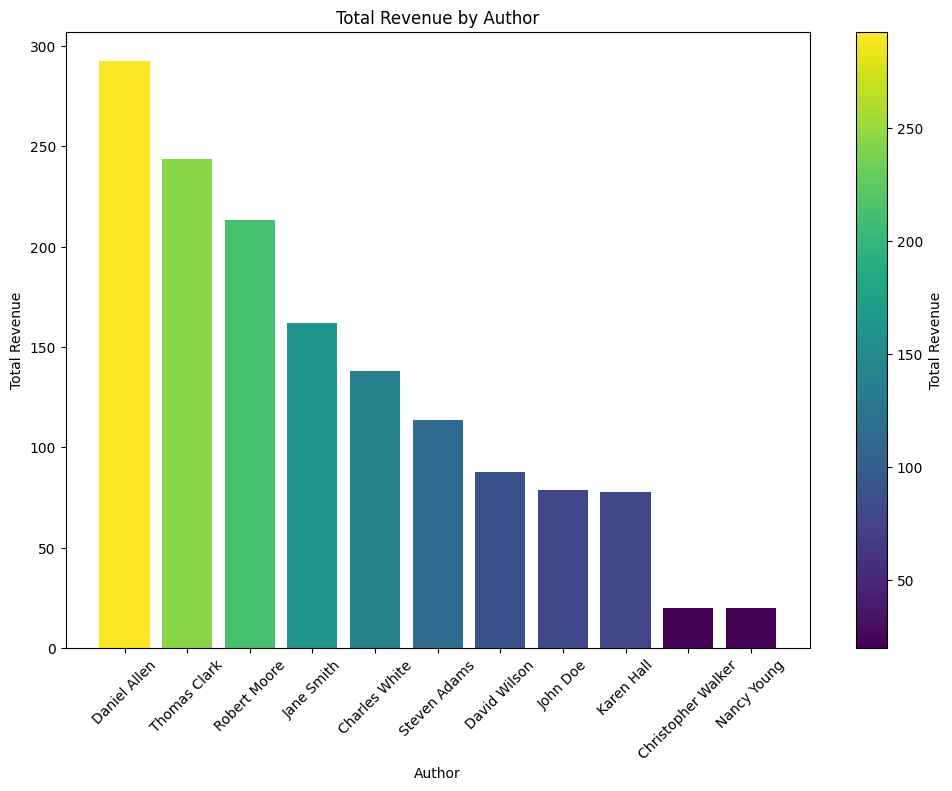

In [ ]:
# Concatenate author names for plotting
authors_revenue_df['AuthorName'] = authors_revenue_df['FirstName'] + ' ' + authors_revenue_df['LastName']
authors_revenue_df

# Color mapping based on revenue
norm = plt.Normalize(authors_revenue_df['TotalRevenue'].min(), authors_revenue_df['TotalRevenue'].max())
colors = plt.cm.viridis(norm(authors_revenue_df['TotalRevenue']))

# Plotting the data
fig1, ax1 = plt.subplots(figsize=(12, 8))
bars = ax1.bar(authors_revenue_df['AuthorName'], authors_revenue_df['TotalRevenue'], color=colors)
ax1.set_xlabel('Author')
ax1.set_ylabel('Total Revenue')
ax1.set_title('Total Revenue by Author')
plt.xticks(rotation=45)
fig1.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax1, label='Total Revenue')
plt.show()

author_revenue_chart = fig1

By concatenating the `FirstName` and `LastName` of each of the authors and creating a color map based on revenue, we use the library matplotlib to visualize the resulting dataframe of the query. The bar plot shows that the top five authors based on revenue are Daniel Allen, Thomas Clark, Robert Moore, Jane Smith, and Charles White. The results can help the bookstore management ensure they have adequate supply of books from these popular authors. The bookstore should also be cautious about purchasing too many books from authors who do not sell well to avoid overstocking and potential loss.

## 2. Which genres should the bookstore consider expanding its inventory of?

In [ ]:
genre_count_revenue_query = """
SELECT B.Genre, COUNT(DISTINCT O.CustomerID) AS CustomerCount, SUM(OI.Quantity * OI.UnitPrice) AS TotalRevenue
FROM Bookstore.Book B
INNER JOIN Bookstore.OrderItem OI ON OI.BookID = B.BookID
INNER JOIN Bookstore.Orders O ON O.OrderID = OI.OrderID
GROUP BY B.Genre
ORDER BY TotalRevenue DESC;
"""

genre_df = run_query(genre_count_revenue_query)
genre_df

,Genre,CustomerCount,TotalRevenue
0,Science Fiction,15,667.80
1,Fantasy,5,263.55
2,Adventure,5,251.65
3,Mystery,5,136.68
4,Horror,4,127.80


### Visualizing Revenue by Genre

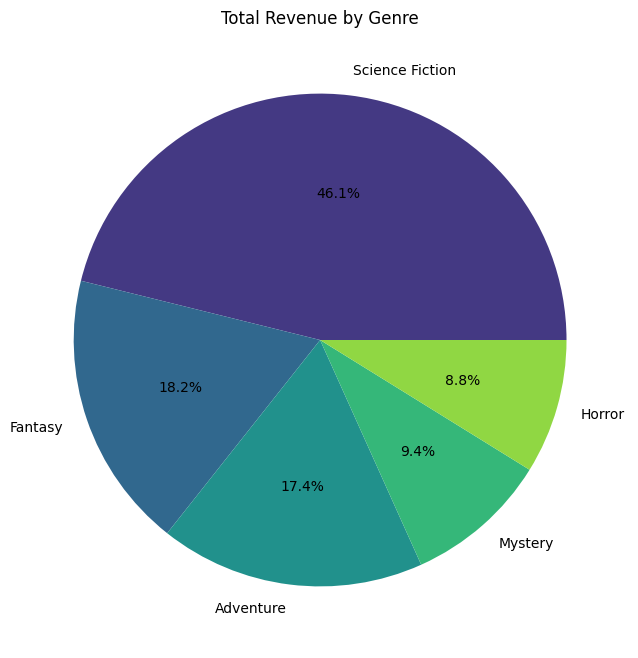

In [ ]:
# Plotting the data for revenue by genre
fig2, ax2 = plt.subplots(figsize=(10, 8))
colors = sns.color_palette('viridis', len(genre_df))
ax2.pie(genre_df['TotalRevenue'], labels=genre_df['Genre'], autopct='%1.1f%%', colors=colors)
ax2.set_title('Total Revenue by Genre')
plt.show()

revenue_genre_chart = fig2

### Visualizing Customer Count by Genre

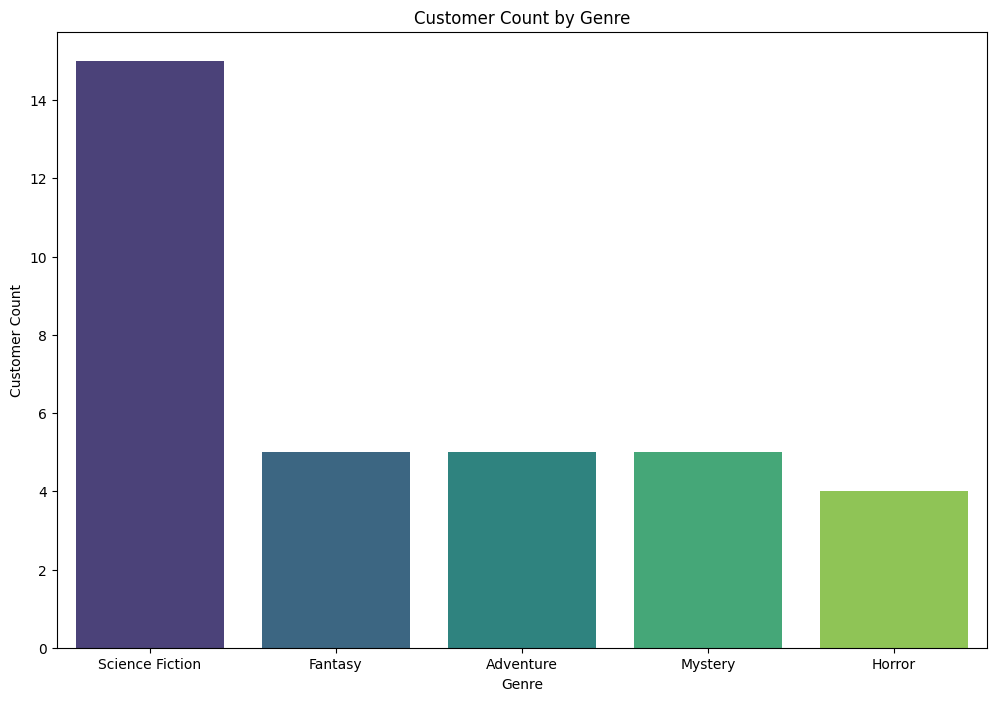

In [ ]:
# Plotting the data for customer count by genre
fig3, ax3 = plt.subplots(figsize=(12, 8))
sns.barplot(x='Genre', y='CustomerCount', data=genre_df, palette='viridis', ax=ax3)
ax3.set_xlabel('Genre')
ax3.set_ylabel('Customer Count')
ax3.set_title('Customer Count by Genre')
plt.show()

customer_count_genre_chart = fig3

From the two charts above, we can see that Science Fiction is the leading genre in terms of both customer interest and revenue. With 15 customers purchasing Science Fiction books, the genre is three times nmore popular than the next highest-selling genre. Sales from Science Fiction books also generate 46.1% of the bookstore's revenue, indicating that the bookstore should expand in the direction of Science Fiction.

## 3. How have sales trends changed over time?

In [ ]:
sales_over_time_query = """
SELECT OrderDate, SUM(TotalAmount) AS TotalRevenue
FROM Orders
GROUP BY OrderDate
ORDER BY OrderDate;
"""

sales_time_df = run_query(sales_over_time_query)
sales_time_df

,OrderDate,TotalRevenue
0,2023-01-01,59.97
1,2023-01-05,49.98
2,2023-01-10,39.99
3,2023-01-15,29.99
4,2023-01-20,19.99
5,2023-01-25,89.97
6,2023-01-30,79.96
7,2023-02-01,69.95
8,2023-02-05,59.94
9,2023-02-10,49.93


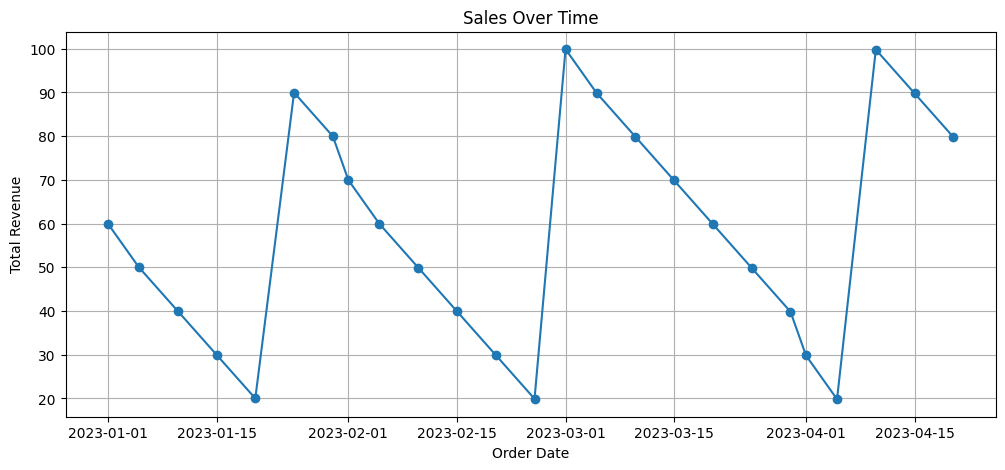

In [ ]:
# Converting OrderDate to datetime
sales_time_df['OrderDate'] = pd.to_datetime(sales_time_df['OrderDate'])

# Creating the plot and naming it sales_over_time_chart
fig4, ax4 = plt.subplots(figsize=(12, 5))
ax4.plot(sales_time_df['OrderDate'], sales_time_df['TotalRevenue'], marker='o')
ax4.set_xlabel('Order Date')
ax4.set_ylabel('Total Revenue')
ax4.set_title('Sales Over Time')
ax4.grid(True)
plt.show()

# Save the plot as sales_over_time_chart
sales_over_time_chart = fig4

The bookstore's revenue has distinct peaks on January 25, March 1, and April 10. After the peaks, revenue typically decreases linearly before shooting back up to a peak again. Overall, it revenua appears to be trending upwards as the peaks get higher and higher over time.

## 4. Which books have above-average ratings?

In [ ]:
highly_rated_books_query = """
SELECT b.Title, CONCAT(a.FirstName, ' ', a.LastName) AS AuthorName, AVG(r.Rating) AS AvgRating
FROM Book b
JOIN Review r ON b.BookID = r.BookID
JOIN Author a ON b.AuthorID = a.AuthorID
GROUP BY b.Title, AuthorName
HAVING AVG(r.Rating) > (
	SELECT AVG(Rating) FROM Review
    )
ORDER BY AvgRating DESC;
"""

highly_rated_books_df = run_query(highly_rated_books_query)

dp.DataTable(highly_rated_books_df)

# Putting it into a Datapane report

Now that we have all our charts defined, we can combine them together into a Datapane report. We'll use Groups to add charts in a grid layout, as well as BigNumbers, Plots and DataTables.

In [ ]:
# calculate BigNumbers for the report

order_item_query = """
SELECT * FROM OrderItem;
"""

order_item_df = run_query(order_item_query)

# Calculate total number of orders
total_orders = order_item_df["OrderID"].nunique()

total_revenue = (order_item_df["Quantity"] * order_item_df["UnitPrice"]).sum()
total_books_sold = order_item_df["Quantity"].sum()
average_order_value = round(total_revenue / total_orders, 2)

In [33]:
r = dp.Report(
    dp.Group(
        dp.BigNumber(heading="Total Revenue (dollars)", value=total_revenue),
        dp.BigNumber(heading="Total Books Sold", value=total_books_sold),
        dp.BigNumber(heading="Average Order Value (dollars)", value=average_order_value),
        columns=3,
        name="Little_group",
    ),
    dp.Text("## Revenue Analysis"),
    dp.Text("### Which authors and genres have generated the most revenue for the bookstore?"),
    dp.Group(
        dp.Plot(author_revenue_chart, name="Total_Revenue_by_Author"),
        dp.Plot(revenue_genre_chart, name="Total_Revenue_by_Genre"),
        columns=2,
    ),
    dp.Text("### How much revenue has the bookstore made from orders based on status?"),
    dp.DataTable(completed_revenue_df, name="Revenue_by_Order_Status"),
    dp.Text("### How have the sales trends been changing over time?"),
    dp.Plot(sales_over_time_chart, name="Revenue_Over_Time"),

    dp.Text("## Inventory Analysis\n### How many books do we have in stock for each genre?"),
    dp.DataTable(genre_count_df, name="Inventory_Count_by_Genre"),

    dp.Text("## Popularity Analysis\n### Which genres are the bookstore's customers purchasing more of?"),
    dp.Plot(customer_count_genre_chart, name="Customer_Count_by_Genre"),
    dp.Text("### What are the top ten best-selling authors and books based on number of copies sold?"),
    dp.Plot(top_ten_authors_chart, name="Top_Ten_Authors_with_Counts"),
    dp.Text("### What are the top ten best-selling books based on number of copies sold?"),
    dp.Group(
        dp.DataTable(top_ten_books_df, name="Top_Ten_Books_with_Authors_and_Counts"),
        dp.Plot(top_ten_books_chart, name="Top_Ten_Books_Chart"),
        columns=2,
    ),

    dp.Text("## Ratings Analysis\n### Which books have above-average ratings?"),
    dp.DataTable(highly_rated_books_df, name="Highly_Rated_Books_with_Authors"),
    dp.Text("### What is the average rating given by each customer that has completed at least one review?"),
    dp.Group(
        dp.DataTable(review_df, name="Average_Review_per_Customer"),
        dp.Plot(average_ratings_distribution_chart, name="Average_Ratings_BoxPlot"),
        columns=2,
    )
)

dp.save_report(r, "report.html", open=True)

App saved to ./report.html

In [34]:
import IPython
IPython.display.HTML(filename='report.html')